<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#First-Order-Shift,-Constant-Phase-Shift" data-toc-modified-id="First-Order-Shift,-Constant-Phase-Shift-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>First Order Shift, Constant Phase Shift</a></span><ul class="toc-item"><li><span><a href="#Phase-Ramp-on-Alternate-Lines" data-toc-modified-id="Phase-Ramp-on-Alternate-Lines-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Phase Ramp on Alternate Lines</a></span></li><li><span><a href="#Fourier-Transforms-of-the-Phase-Ramps" data-toc-modified-id="Fourier-Transforms-of-the-Phase-Ramps-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Fourier Transforms of the Phase Ramps</a></span></li></ul></li><li><span><a href="#Multiplication-of-K-space-and-Phase-Ramps" data-toc-modified-id="Multiplication-of-K-space-and-Phase-Ramps-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Multiplication of K-space and Phase Ramps</a></span></li><li><span><a href="#Convoluting-Phase-Rampss-in-Image-Space" data-toc-modified-id="Convoluting-Phase-Rampss-in-Image-Space-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Convoluting Phase Rampss in Image Space</a></span></li></ul></li><li><span><a href="#Inspecting-the-Blurring-Caused-by-Alternate-Line-Phase-Ramps" data-toc-modified-id="Inspecting-the-Blurring-Caused-by-Alternate-Line-Phase-Ramps-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Inspecting the Blurring Caused by Alternate Line Phase Ramps</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Seprate-K-Space-Lines-that-were-shifted-by-Ramps" data-toc-modified-id="Seprate-K-Space-Lines-that-were-shifted-by-Ramps-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Seprate K-Space Lines that were shifted by Ramps</a></span></li></ul></li><li><span><a href="#Displaying-the-Individual-Images-and-their-Overlay" data-toc-modified-id="Displaying-the-Individual-Images-and-their-Overlay-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Displaying the Individual Images and their Overlay</a></span></li><li><span><a href="#Padding-Lines-of-K-space-to-increase-FOV" data-toc-modified-id="Padding-Lines-of-K-space-to-increase-FOV-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Padding Lines of K-space to increase FOV</a></span></li></ul></li></ul></div>

### First Order Shift, Constant Phase Shift

In [1]:
import BrukerMRI as bruker
import pylab as pl
import plot
#Python method of extracting raw Bruker Files
import BrukerMRI as bruker
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
# Modules
from mpl_toolkits.axes_grid1 import ImageGrid
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, HBox
from mpl_toolkits.axes_grid1 import make_axes_locatable


import pandas as pd
import pydicom as dcm
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
from os.path import expanduser
import os
from matplotlib import cm
import cmath

In [2]:
# copy and paste entire directory but replace "\" with "/"
# Place a "/" at the end of the line
MainDir = "C:/Users/daniala/Desktop/mri/20191210_104049_MRMD_phantom_practice_1_3/"
ExpNum = 8
Experiment = bruker.ReadExperiment(MainDir, ExpNum)
acqp = Experiment.acqp
method = Experiment.method
raw_fid = Experiment.raw_fid
k_space_gen = Experiment.GenerateKspace()
k_space = Experiment.k_data
k_sp = bruker.phase_shift(120,0,k_space)[:,:,0]

In [3]:
def k_plots(k_spaces):
    
    key_list = list(k_spaces)
    Nr = len(list(k_spaces))
    Nc = 2

    fig = plt.figure(figsize = (30,20))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(Nr, Nc),  # creates 2x3 grid of axes
                     axes_pad=0.8,  # pad between axes in inch.
                     share_all=False,
                     cbar_location="right",
                     cbar_mode="each",
                     cbar_size="7%",
                     cbar_pad="5%",
                     )
    
    for key,value in k_spaces.items():
        c = key_list.index(key)
        
        im = grid[2*c].imshow(np.log(1+np.abs(value[:,:])))
        grid[2*c].set_xticks([])
        grid[2*c].set_yticks([])
        grid[2*c].set_title('k-space of ' + key)
        cb = grid.cbar_axes[2*c].colorbar(im)

        im2 = grid[1+2*c].imshow(abs(plot.fft_image(value[:,:])))
        grid[1+2*c].set_xticks([])
        grid[1+2*c].set_yticks([])
        grid[1+2*c].set_title('Image from ' + key)
        cb = grid.cbar_axes[1+2*c].colorbar(im2)


#### Phase Ramp on Alternate Lines

In [4]:
def phase_ramp_1(del_x,del_y,x,y,k_sp):
    shape = k_sp.shape
    N_x = shape[0]
    N_y = shape[1]
    
    p_ramp = np.ones((N_x,N_y),dtype='complex')
    ky = (np.linspace(0,N_y-1,N_y)-(N_y/2))/N_y  
    kx = (np.linspace(0,N_x-1,N_x)-(N_x/2))/N_x
    if x > 0:
        for i in range(0,N_x-1,x):
            p_ramp[i,:] = np.exp(-1j*del_x*kx*2*np.pi)
    if y > 0:         
       for i in range(0,N_y-1,y):
           p_ramp[:,i] = p_ramp[:,i] * np.exp(-1j*del_y*ky*2*np.pi)
        
    return(p_ramp)

In [5]:
first_x = phase_ramp_1(5,0,2,0,k_sp)
first_y = phase_ramp_1(0,5,0,2,k_sp)
first_xy = phase_ramp_1(5,5,2,2,k_sp)

#### Fourier Transforms of the Phase Ramps

In [6]:
first_x1 = phase_ramp_1(5,0,2,0,k_sp[0:30,0:30])
first_y1 = phase_ramp_1(0,5,0,2,k_sp[0:30,0:30])
first_xy1 = phase_ramp_1(5,5,2,2,k_sp[0:30,0:30])

C:\Users\daniala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Attempting to set identical bottom == top == 0.6931471805599453 results in singular transformations; automatically expanding.


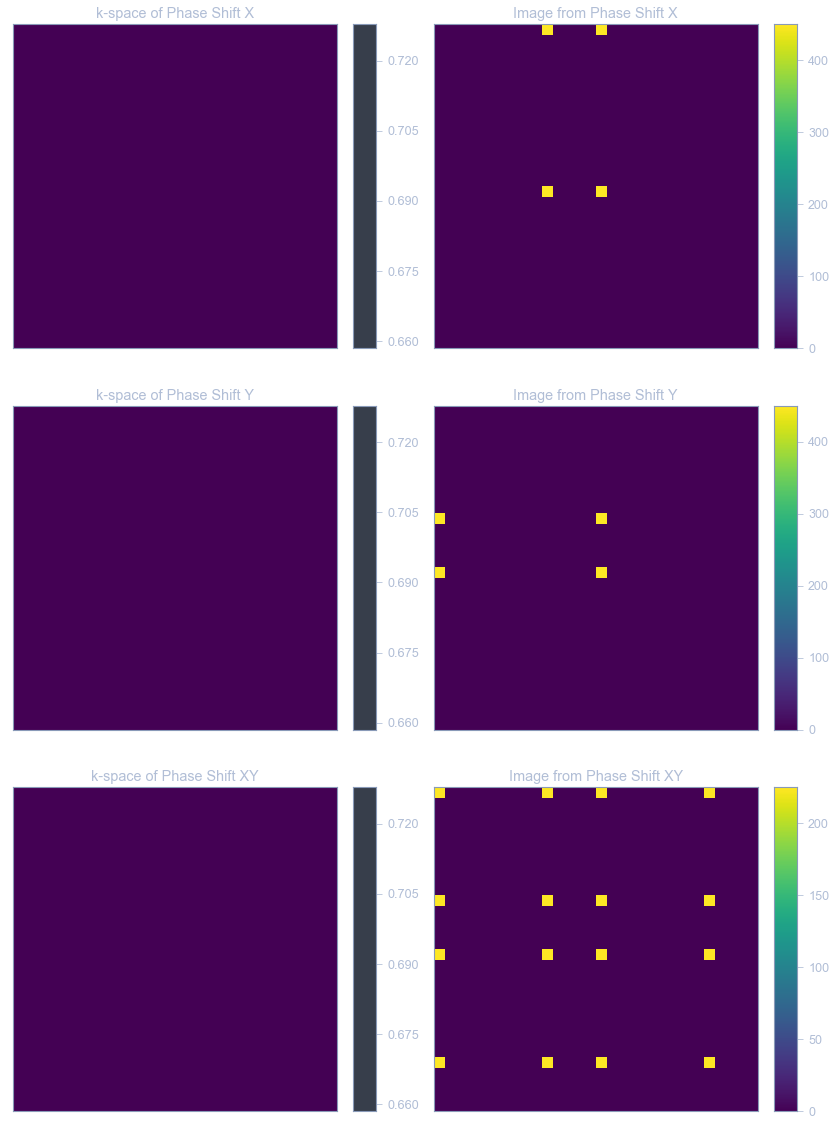

In [7]:
k_spaces = {#'Original k-space':k_sp,
            'Phase Shift X':first_x1,
            'Phase Shift Y': first_y1,
            'Phase Shift XY': first_xy1
            }

k_plots(k_spaces)

### Multiplication of K-space and Phase Ramps

In [8]:
k_first_x = np.multiply(k_sp,first_x)
k_first_y = np.multiply(k_sp,first_y)
k_first_xy = np.multiply(k_sp,first_xy)

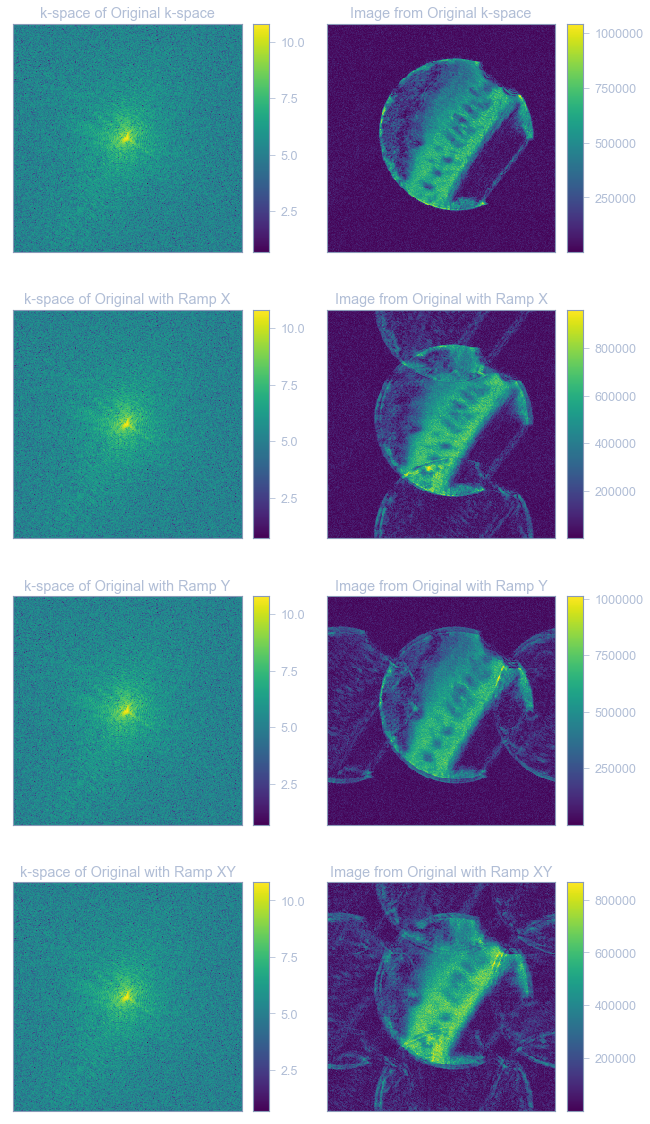

In [9]:
k_spaces2 = {'Original k-space':k_sp,
            'Original with Ramp X': k_first_x,
            'Original with Ramp Y': k_first_y,
            'Original with Ramp XY': k_first_xy
            }
k_plots(k_spaces2)

### Convoluting Phase Rampss in Image Space

In [10]:
from scipy import signal
image_first_x = signal.convolve2d(plot.fft_image(k_sp),plot.fft_image(first_x), boundary='symm', mode='same')
image_first_y = signal.convolve2d(plot.fft_image(k_sp),plot.fft_image(first_y), boundary='symm', mode='same')
image_first_xy = signal.convolve2d(plot.fft_image(k_sp),plot.fft_image(first_xy), boundary='symm', mode='same')

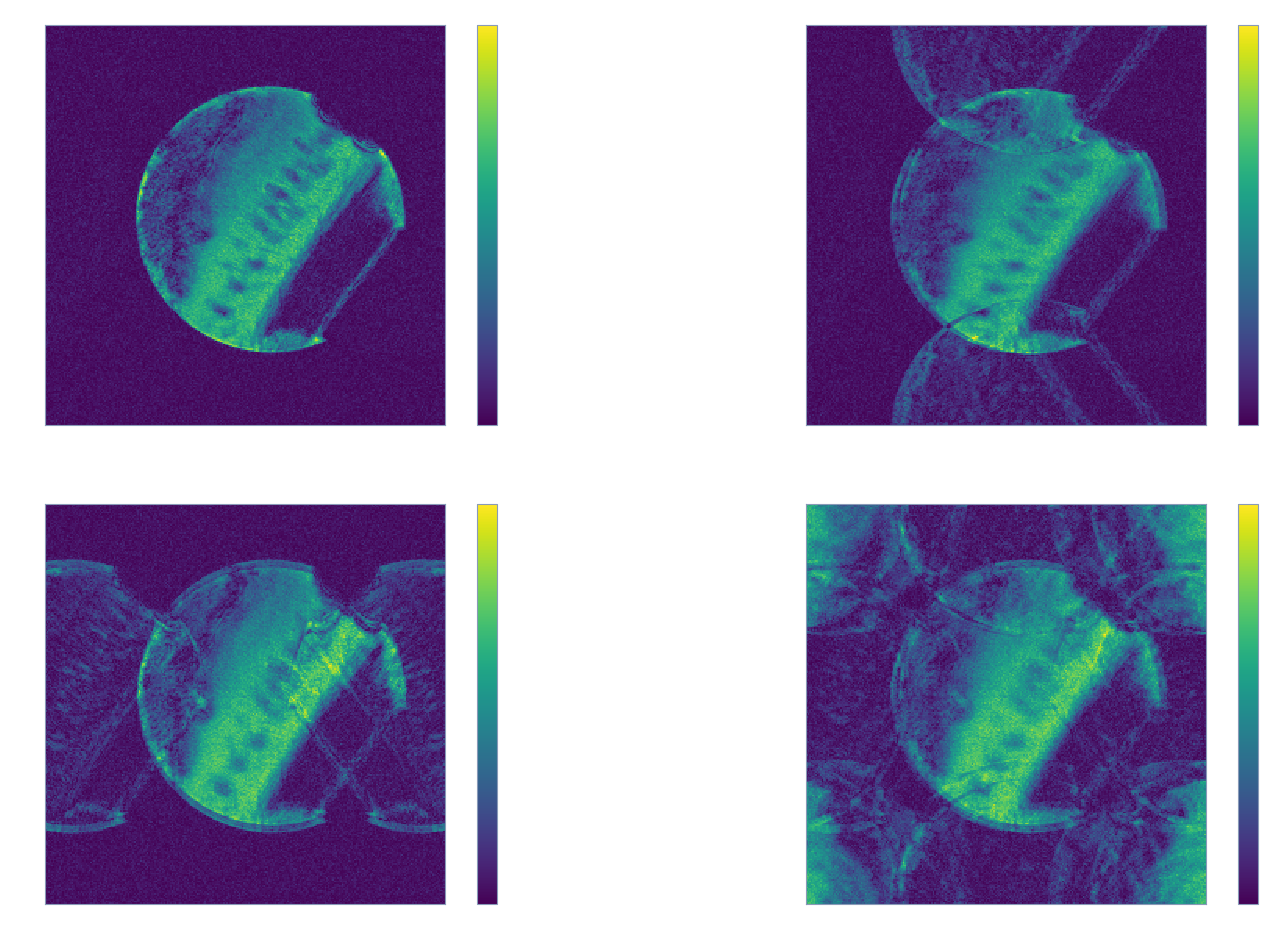

In [11]:
k_spaces1 = {'Original k-space':plot.fft_image(k_sp),
            'Convolution of Original Image with Phase Ramp X': image_first_x,
            'Convolution of Original Image with Phase Ramp Y': image_first_y,
            'Convolution of Original Image with Phase Ramp XY': image_first_xy,

            }

plot.comparison_i_plots(k_spaces1)

## Inspecting the Blurring Caused by Alternate Line Phase Ramps

#### Seprate K-Space Lines that were shifted by Ramps

In [12]:
original = range(0,256,2)
shifted = range(1,256,2)

In [55]:
k_first_x_original = k_first_x[original]
k_first_x_shifted = k_first_x[shifted]
k_first_y_original = k_first_y[:,original]
k_first_y_shifted = k_first_y[:,shifted]

In [56]:
img_1 = np.fft.fftshift(np.fft.fft2(k_first_x_original))
img_2 = np.fft.fftshift(np.fft.fft2(k_first_x_shifted))

img_3 = np.fft.fftshift(np.fft.fft2(k_first_y_original))
img_4 = np.fft.fftshift(np.fft.fft2(k_first_y_shifted)) 



### Displaying the Individual Images and their Overlay

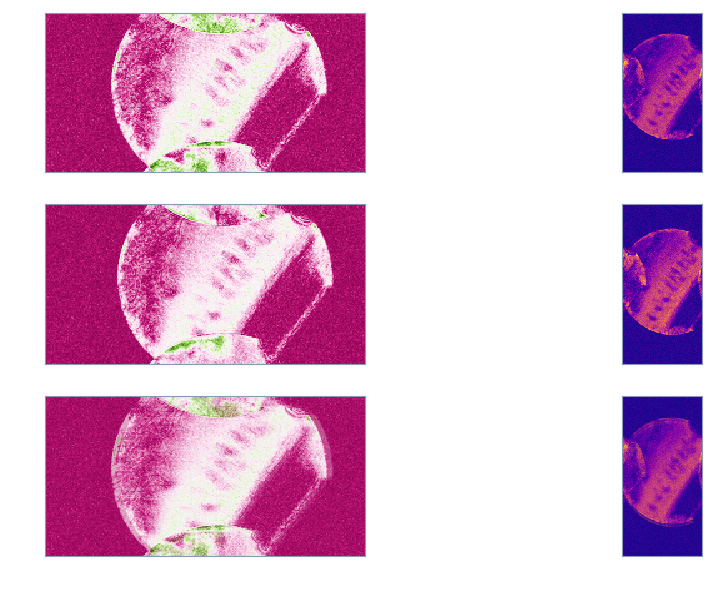

In [59]:
plt.figure(figsize=(15,10))


plt.subplot(321)
plt.imshow(abs(img_1),cmap='PiYG')

plt.subplot(323)
plt.imshow(abs(img_2),cmap ='PiYG')

plt.subplot(325)
plt.imshow(abs(img_2),cmap ='PiYG')
plt.imshow(abs(img_1),cmap ='PiYG',alpha = 0.7)

plt.subplot(322)
plt.imshow(abs(img_3),cmap='plasma')

plt.subplot(324)
plt.imshow(abs(img_4),cmap ='plasma')

plt.subplot(326)
plt.imshow(abs(img_4),cmap ='plasma')
plt.imshow(abs(img_3),cmap ='plasma',alpha = 0.7)

### Padding Lines of K-space to increase FOV

In [68]:
k_x = np.zeros((256,256),dtype='complex')
k_x[original] = k_first_x_original
img_1_pad = np.fft.fftshift(np.fft.fft2(k_x))

In [69]:
k_x_shift = np.zeros((256,256),dtype='complex')
k_x_shift[shifted] = k_first_x_shifted
img_2_pad = np.fft.fftshift(np.fft.fft2(k_x_shift))

In [70]:
k_y = np.zeros((256,256),dtype='complex')
k_y[:,original] = k_first_y_original
img_3_pad = np.fft.fftshift(np.fft.fft2(k_y))

In [71]:
k_y_shift = np.zeros((256,256),dtype='complex')
k_y_shift[:,shifted] = k_first_y_shifted
img_4_pad = np.fft.fftshift(np.fft.fft2(k_y_shift))

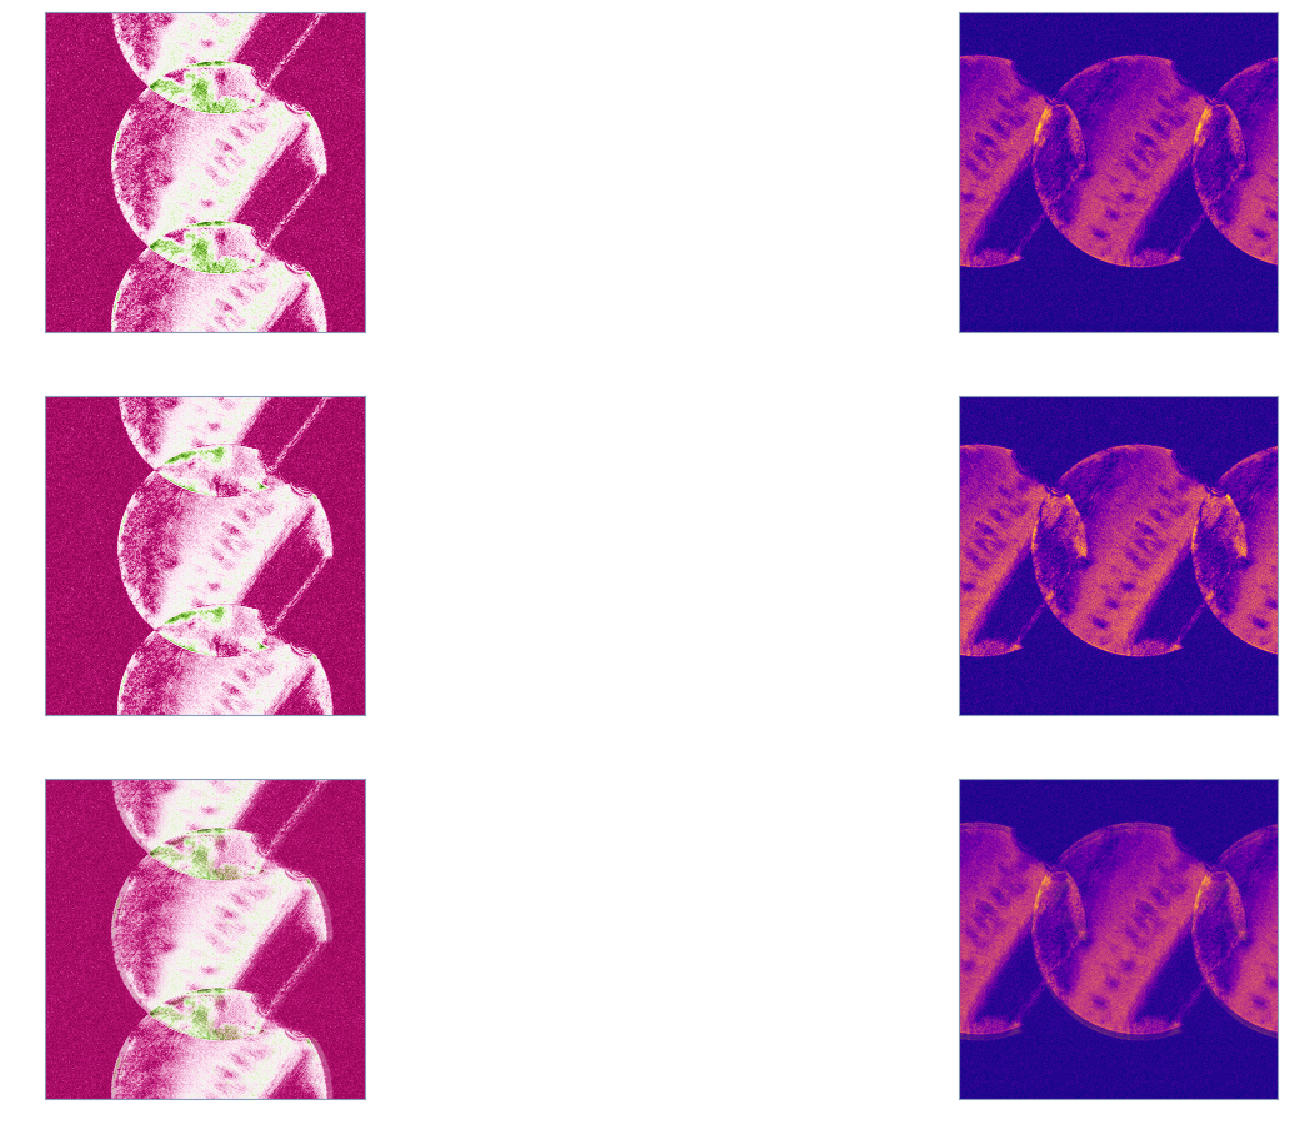

In [73]:
plt.figure(figsize=(30,20))


plt.subplot(321)
plt.imshow(abs(img_1_pad),cmap='PiYG')

plt.subplot(323)
plt.imshow(abs(img_2_pad),cmap ='PiYG')

plt.subplot(325)
plt.imshow(abs(img_2_pad),cmap ='PiYG')
plt.imshow(abs(img_1_pad),cmap ='PiYG',alpha = 0.7)

plt.subplot(322)
plt.imshow(abs(img_3_pad),cmap='plasma')

plt.subplot(324)
plt.imshow(abs(img_4_pad),cmap ='plasma')

plt.subplot(326)
plt.imshow(abs(img_4_pad),cmap ='plasma')
plt.imshow(abs(img_3_pad),cmap ='plasma',alpha = 0.7)